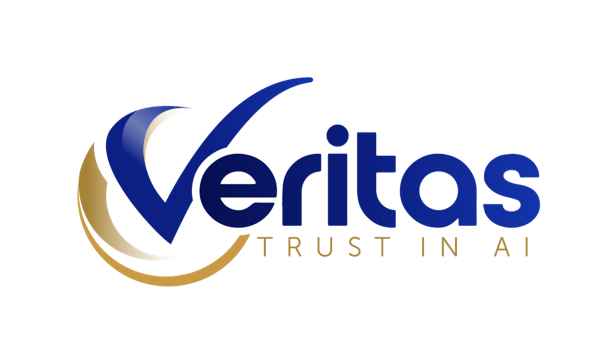

# Veritas Tool : Base Regression Model 
    
<p>   
    The <b>Veritas toolkit</b> is comprised of diagnosis tool and assessment tool.
    This scenario is to build a regression model and use daignosis tool to evaluate model & produce
    the model artifact required by assessment tool to generate the fairness & transparency assessment report.
</p>    
<p>    
    Base regression model is a regression model for prediction of continuous target variable. <br/>
    Steps to perform: <br/>
    1. Loading Data and Model <br/>  
    2. Fairness Diagnosis and Transparency Assessment <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.1 compute performance and fairness metrics <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.2 compute feature importance analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3 compute transparency analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.4 save results in json artifact <br/>
</p>

# 1. Loading Data and Model

## Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys  
from pathlib import Path
# making veritas available in search path
sys.path.append('../../')
import os
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb
from sklearn.base import BaseEstimator

In [3]:
from veritastool.model.modelwrapper import ModelWrapper
from veritastool.model.model_container import ModelContainer
from veritastool.usecases.predictive_underwriting import PredictiveUnderwriting

/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for 

## Loading Data

In [8]:
pth = os.path.abspath('.')

#Load Base Regression pickle file
file = os.path.join(pth, 'data',"regression_dict.pickle") 
input_file = open(file, "rb")
br = pickle.load(input_file)

#Model Container Parameters
x_train = br["x_train"]
x_test = br["x_test"]
y_train = np.array(br["y_train"])
y_true = np.array(br["y_test"])
y_pred = np.array(br["y_pred"])
p_grp = {'sex': [1], 'children': 'maj_min'}

Trying to unpickle estimator LinearRegression from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


## Data Exploration

In [4]:
print("No of rows: {} \nNo. of columns: {}".format(x_train.shape[0],x_train.shape[1]))
x_train.head()

Traceback (most recent call last):
  File "/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_23929/3576309545.py", line 1, in <module>
NameError: name 'x_train' is not defined


## Building Model

In [5]:
params = {
    'objective': 'reg:squarederror',  # Regression task with mean squared error loss
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100,             # Number of boosting rounds
    'seed': 42
}


In [6]:
class XGBWrapper(BaseEstimator):
    def __init__(self, params=None):
        self.params = params
        self.model = None
        self.classes_ = None 

        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.model = xgb.train(self.params, dtrain)
        return self
        
    def predict(self, x_test):
        dtest = xgb.DMatrix(x_test)
        return self.model.predict(dtest)

In [7]:
model_object = XGBWrapper(params=params)
model_object.fit(x_train, y_train)
model_name = "base_regression"
model_type = "regression"

Traceback (most recent call last):
  File "/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_23929/632918625.py", line 2, in <module>
NameError: name 'x_train' is not defined


# 2. Fairness Diagnosis and Transparency Assessment

## Import Veritas Library

Veritas Library use case object creation includes two step. In the first step, Model_Container object is created with generic machine learning inputs. In the second step, use case object is created with Model_Container object and use case specific inputs. BaseRegression is showcased in this notebook.

In [30]:
from veritastool.model.model_container import ModelContainer
from veritastool.usecases.base_regression import BaseRegression

## Initializing Veritas Library

In [31]:
#Create Model Container 
container = ModelContainer(y_true, p_grp, model_type, model_name, y_pred, y_train=y_train, x_train=x_train, x_test=x_test, model_object=model_object)

<h5 align="center">Table 1: Model Container parameters   </h5>

| Var Name    | Category       |Sub-category   | Description   |  Value        |  Compulsory   |
| :---        |    :----:      |   :----:      |          ---: |          ---: |        ---: |
| y_true      | data           | testing       | test set labels| array([42303.69,...,6313.75] |Yes|
| y_pred      | data           | testing       | test set predicted labels | array([35896.54,...,8173.11]   |Yes|
| y_prob      | data           | testing       | test set predicted probabilities | -|No|
| x_test      | data           | testing       | test set features | -      |No|
| y_train     | data           | training      | train set labels      | array([10594.22,...,12981.34]    |No|
| x_train     | data           | training      | train set features |-      |No|
| p_grp       | protected vars |    -          | list of privileged groups| { 'sex': [ 1 ] , 'children': 'maj_min' }   |Yes|
| model_obj   | model          |    -          | model to assess| -      |No|
| model_type  | model          |    -          | type of model | 'regression'    |Yes|
| model_name  | model          |    -          | name of model | 'regression'   |No|


In [32]:
#Create Use Case Object
base_reg_obj= BaseRegression(model_params = [container], fair_threshold = 80, perf_metric_name = "mape", \
                             fair_concern = "eligible", fair_priority = "benefit", fair_impact = "normal", \
                             tran_row_num = [1,10,25], tran_max_sample = 1, tran_pdp_feature = ['age','bmi'])

<h5 align="center">Table 2: Base Regression parameters   </h5>

| Var Name    | Category       | Description   |  Value        |Compulsory|
| :---        |    :----:      |          ---: |          ---: |---:|
| model_params| model containers | list of model containers | -  |Yes|
| fair_threshold | fairness metric thresolding |threshold used for assessment|floating value between 0 and 1 (treated as actual <br/> value) or 1 and 100 (treated as p%)   |No|
| fair_concern |fair_metric selection| for auto-suggestion: most concerned cohort| "eligible" or "inclusive" or "both" |No|
| fair_priority| fair_metric selection| for auto-suggestion: top priority to be for fairness assessment | "benefit" or "harm" |No|
| fair_impact  | fair_metric selection | for auto-suggestion: impact magnitude and type | "normal" or "significant" or "selective"   |No|
| fair_metric_type  | fair_metric selection | for auto-suggestion: type of metric | "difference" or "ratio"  |No|
| fair_metric_name      | metric name |primary fairness metric | "auto" or any of supported ones <br/> like "expected_harm"   |No|
| perf_metric_name      | metric name |primary performance metric |"expected_profit"   |Yes|
| tran_row_num      | transparency parameter |row number for local interpretability plot starting with 1 |list of integers   |No|
| tran_max_sample      | transparency parameter |sampling size for transparency analysis |float value between 0 and 1 (treated as <br/> percentage of rows)  or  int treated as #rows   |No|
| tran_pdp_feature      | transparency parameter |feature list for pdp plots |list of features   |No|
| tran_pdp_target      | transparency parameter |class label for pdp plots(required for multi-class model) |string |No|
| tran_max_display      | transparency parameter |#features to be displayed in the transparency plots |int    |No|
| tran_processed_data      | transparency parameter |sample dataframe for the analysis incase x_train is a string |dataframe    |No|
| tran_processed_label      | transparency parameter |list of y_train(s) for the given tran_processed_data |list    |No|






## Starting Fairness diagnosis

In [12]:
base_reg_obj.evaluate()

Evaluate performance:   0%|          




Performance Metrics
	Root Mean Squared Error                               6134.957 +/- 584.331
	Mean Absolute Percentage Error                             0.419 +/- 0.045
	Weighted Absolute Percentage Error                         0.307 +/- 0.027


Primary Fairness Metric Suggestion
	Root Mean Squared Error Parity
based on
	fair_priority = benefit
	fair_concern = eligible
	fair_impact = normal
	fair_metric_type = difference


-----------------------------------1: Sex---------------------------------------
Value Distribution
	Privileged Group                                                   50.249%
	Unprivileged Group                                                 49.751%


Fairness Metrics
	Root Mean Squared Error Parity                       -182.457 +/- 1236.502
	Mean Absolute Percentage Error Parity                      0.074 +/- 0.085
	Weighted Absolute Percentage Error Parity                 -0.009 +/- 0.048


Fairness Conclusion
	Outcome (Root Mean Squared Error Parity)    

In [13]:
base_reg_obj.evaluate(visualize = True, output = True) 

In [14]:
base_reg_obj.feature_importance()

Feature importance:   0%|          




--------------------------------------------------1: Fairness on Sex--------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------
|Removed Protected Variable    |mape                     |rmse_parity              |Fairness Conclusion |Suggestion        |
----------------------------------------------------------------------------------------------------------------------------
|sex                           |-0.079                   |347.658                  |fair to fair (+)    |Exclude           |
----------------------------------------------------------------------------------------------------------------------------
|children                      |-0.066                   |274.914                  |fair to fair (+)    |Exclude           |
-------------------------------------------------------------------------------------------------------------------------

[10:41:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[10:41:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



Correlation analysis :   0%|          


Partial correlation matrix (Most correlated features for sex, children):


,smoker,sex,children,age,bmi
smoker,1.000000,0.057628,0.024922,0.047515,0.000000
sex,0.057628,1.000000,0.000000,0.000000,0.000000
children,0.024922,0.000000,1.000000,0.358639,0.000000
age,0.047515,0.000000,0.358639,1.000000,0.255585
bmi,0.000000,0.000000,0.000000,0.255585,1.000000


* No surrogate detected based on correlation analysis (threshold=0.7).


## Starting Transparency Assessment

Running transparency for model 1        done      
     Data preparation                   done      


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


     Interpretability                   done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      


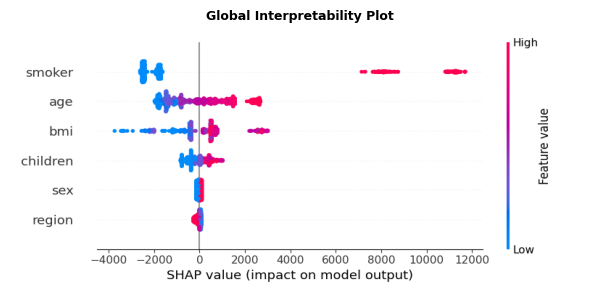

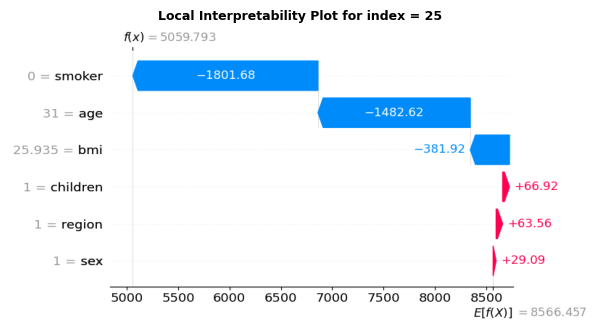

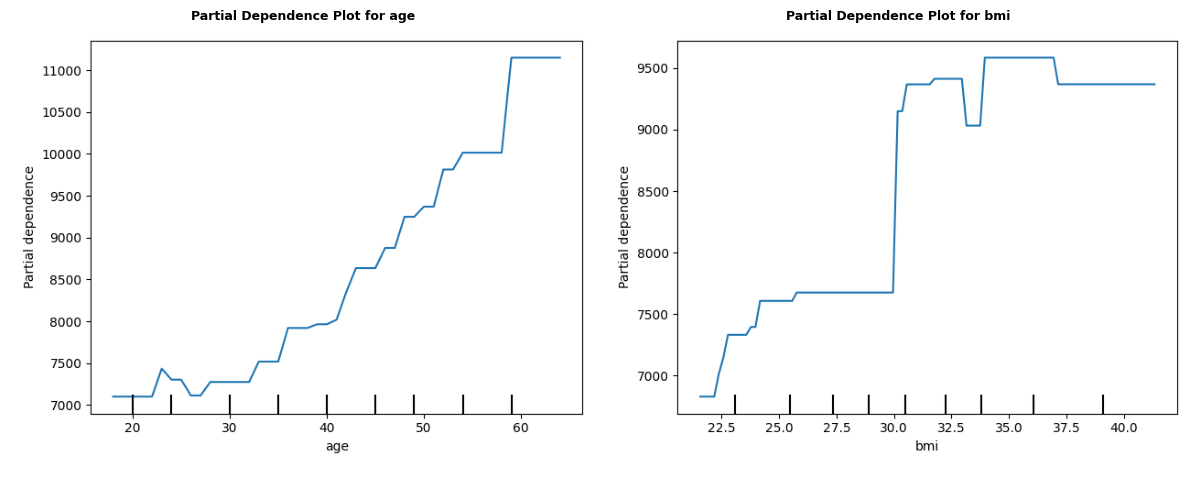

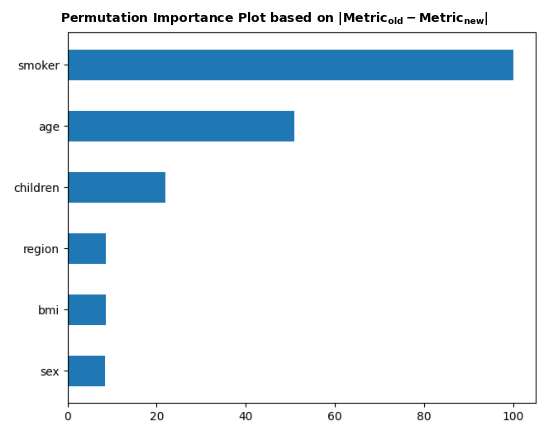

In [33]:
#Run the entire transparency analysis
base_reg_obj.explain()

<h5 align="center">Table 3: Transparency parameters   </h5>

| Var Name    | Description   |  Value        |Default|Compulsory|
| :---        |          ---: |          ---: |---:|---:|
| disable | disable any of the transparency analysis |list of valid inputs ['interpret','partial_dep','perm_imp']  |blank list |No|
| local_row_num |row number for local interpretability plot |integer   |last value of tran_row_num |No|
| model_num   |model for which assessment is required |1 or 2   |last model in model container |No|
| output      |boolean value for displaying the plots |True or False   |True |No|





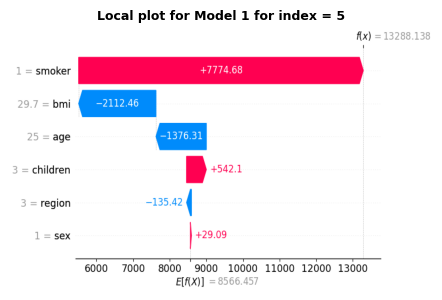

In [34]:
#Get the local interpretability plot for a specific row index
base_reg_obj.explain(local_row_num = 5)

   ## Compiling Results 

In [35]:
#Compile fairness diagnosis & transparency assessment results
base_reg_obj.compile()

Evaluate performance:   0%|          


Running evaluate                        done      
     performance measures               done      
     bias detection                     done      
     probability calibration            skipped   
     performance dynamics               skipped   
     individual fairness                skipped   
Running tradeoff                        skipped   


Feature importance:   0%|          

[10:53:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[10:53:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



Correlation analysis :   0%|          

Running feature importance              done      
     leave-one-out analysis             done      
     correlation analysis               done      
Running transparency for model 1        done      
Generating model artifact               done
Saved model artifact to model_artifact_base_regression_20230817_1053.json
